# Graph Input Format
The input format is given in the following:<br>
1 (0.502987,0.528829) 8 28 102 162 233 360 393 460 500<br>
Index (Coordinates) Number_of_Edges edge1 edge2 edge3...

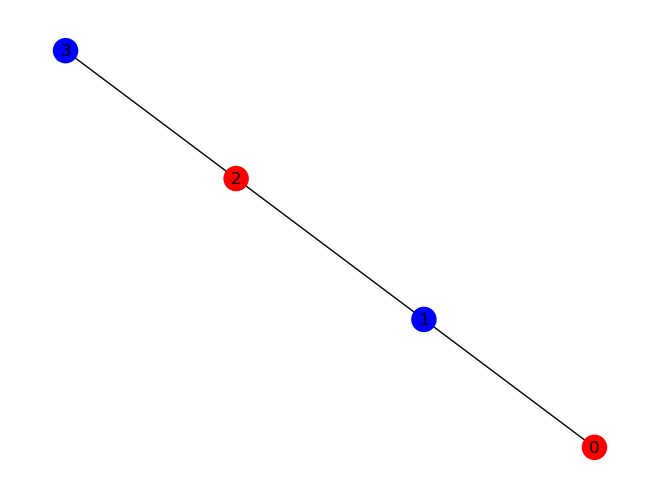

In [81]:
import networkx as nx
import matplotlib.pyplot as plt

#Show Graph:
def vizualize_graph(G):
    pos = nx.spring_layout(G)
    color_map = [G.nodes[node]['color'] for node in G]   
    nx.draw(G, pos, with_labels=True,node_color=color_map)
    plt.show()


#Parsing Graph
def parse_graph(filename, viz=False):
    G = nx.Graph()
    with open(filename,'r') as file:
        lines = file.readlines()
        vertices = []
        edges = []
        color="blue"
        for line in lines:
            color="red" if color=="blue" else "blue"
            line_info = line.split(" ")
            vertex = int(line_info[0].strip())
            vertices.append((vertex,{"color":color}))
            for i in range(1,int(line_info[2].strip())+1):
                edges.append((vertex,int(line_info[2+i].strip())))
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    if(viz):
        vizualize_graph(G)
    return G

parse_graph("tests/simpleTest.txt",viz=True)
            

# Graph bipartition
Fiduccia–Mattheyses algorithm, improvement over Kernighan Lin, but moves only single vertex at a time O(n) per pass.

Datastructure recommended
Array of doubly linked list

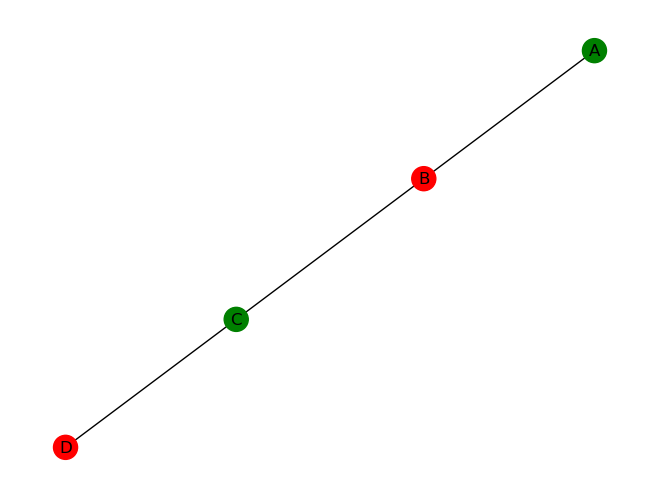

1
A
B
C
D


In [88]:
class gainBucket:
    def __init__(self,gainIndex):
        self.next
        self.previous

def calculateGain(G:nx.Graph,node)->int:
    """
    The gain is calculated by the amount of connections to nodes of the same, and of the other color. 
    all nodes of the same color subtract from the gain, all nodes of the other color add to the gain

    """
    maxGain = 0
    for nd,connected_node in list(G.edges(node)):
        if(G.nodes[connected_node]['color']==G.nodes[node]['color']):
            maxGain-=1
        else:
            maxGain+=1
    return maxGain


    
def initializeBuckets(G,lColor='red'):
    """
    Initializes the gain Buckets by calculating the gains expressed.
    Takes as input the Graph, and the color of the items in the leftBucket
    """
    maxCard = 0
    for vertex in G.nodes:
        maxCard = max(maxCard,G.degree[vertex])
    lBucket = [[] for i in range(0,maxCard*2+1)]
    rBucket = [[] for i in range(0,maxCard*2+1)]
    lBucketsize = 0
    rBucketsize = 0
    #For each node calculate the gain achived by moving the node to the other color, and insert into appropriate index 
    for vertex in G.nodes:
        print(vertex)
        gaindex = calculateGain(G,vertex)+maxCard
        if(G.nodes[vertex]['color']==lColor):
            lBucket[gaindex].append(vertex)
            lBucketsize+=1
        else:
            rBucket[gaindex].append(vertex)
            rBucketsize+=1
    return lBucket,rBucket,lBucketsize,rBucketsize

#Keep the buckets balanced
def bucketSelect(lBucket, rBucket,lBucketsize,rBucketsize):
    if(lBucketsize>=rBucketsize):
        pickBucket = lBucket
        receiveBucket = rBucket
        pickBucketSize = lBucketsize
        receiveBucketSize=rBucketsize
    else:
        pickBucket = rBucket
        receiveBucket = lBucket
        pickBucketSize = rBucketsize
        receiveBucketSize=lBucketsize
    return pickBucket, pickBucketSize, receiveBucket, receiveBucketSize

# returns index and gain from maximum possible move
def findMaximumGain(bucket):
    for i in range(len(bucket),0,-1):
        if(bucket[i]!=[]):
            gain = i
            return gain
    return -1        


def fm_pass(G, lBucket, rBucket,lBucketsize,rBucketsize,colors=("red","blue")):
    """
    performs a single pass of the Fiduccia–Mattheyses algorithm
    """
    pickBucket, pickBucketSize, receiveBucket, receiveBucketSize = bucketSelect(lBucket, rBucket,lBucketsize,rBucketsize)
    maxGain = findMaximumGain(pickBucket)
    while(maxNode!=-1):
        pickBucket[maxGain].pop
        


    return

def fm_search(G:nx.Graph):
    #Calculate maximum cardinality, maximum amount of edges any one vertex has, this is the maximum gain/loss
    #initialize the gain bucket as dictionary of lists
    lBucket,rBucket,lBucketsize,rBucketsize=initializeBuckets(G)
    
    G,lBucket,rBucket,cuts = fm_pass(G,lBucket,rBucket,lBucketsize,rBucketsize)
    return


#G=parse_graph("tests/simpleTest.txt",viz=False)
#fm_search(G)

#Simple Test
vertices = [('A',{"color":"green",}),('B',{"color":"red",}),('C',{"color":"green",}),('D',{"color":"red",})]
edges = [('A','B'),('B','C'),('B','A'),('C','B'),('B','C'),('C','D'),('D','C')]
G1 = nx.Graph()
G1.add_nodes_from(vertices)
G1.add_edges_from(edges)
vizualize_graph(G1)

print(calculateGain(G1,'A'))
assert(calculateGain(G1,'A')==1)
assert(calculateGain(G1,'B')==2)
assert(calculateGain(G1,'C')==2)
assert(calculateGain(G1,'D')==1)

assert(initializeBuckets(G1,lColor="green")==([[], [], [], ['A'], ['C']], [[], [], [], ['D'], ['B']],2,2))
assert(bucketSelect([[], [], [], ['A'], ['C']], [[], [], [], ['D'], ['B']],2,2)==([[], [], [], ['A'], ['C']],2,[[], [], [], ['D'], ['B']],2))
assert(bucketSelect([[], [], [], [], ['C']], [[], [], ['B'], ['D'], ['A']],1,3)==([[], [], ['B'], ['D'], ['A']],3,[[], [], [], [], ['C']],1))
assert(bucketSelect([[], [], ['B'], ['A'], ['C']], [[], [], [], ['D'], []],3,1)==([[], [], ['B'], ['A'], ['C']],3,[[], [], [], ['D'], []],1))

#fm_search(G1)

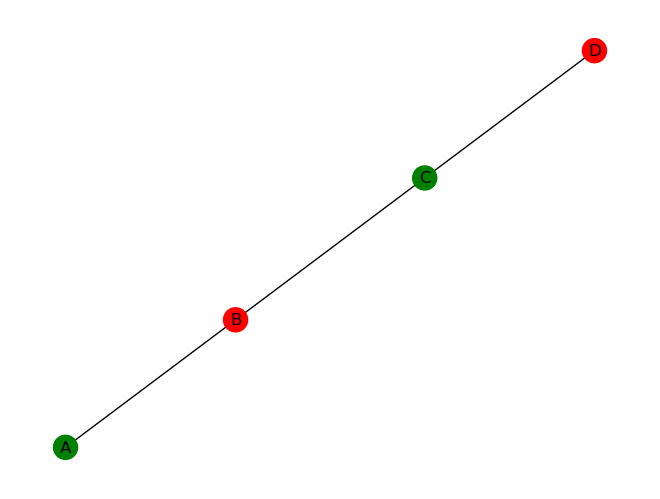

('A', 'B')


KeyError: ('A', 'B')

# Multi-start local search 
Simply restarts local search from a set of randomly generated 
initial solutions. The best local optimum found is returned as final solution.